In [1]:
from gc import callbacks
import os

# for reading and processing images
#import imageio

from skimage.io import imread
from skimage.transform import rescale, resize
# for visualizations
import matplotlib.pyplot as plt
import re
import numpy as np # for using np arrays
import glob
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from skimage.segmentation import find_boundaries

In [2]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    """
    # Make a list for images and masks filenames
    bright_img = []
    fluor_img = []
    
    r = re.compile(r'r(\d+)c(\d+)f(\d+)p(\d+)-ch(\d+)sk(\d+)')
    def custom_key(x):
        val = int(r.search(x).group(5)) * 1_000_000 + int(r.search(x).group(1)) * 100_000 + int(r.search(x).group(2)) * 10_000 + int(r.search(x).group(3)) * 10 + int(r.search(x).group(6))
        return val
    def custom_key2(x):
        val = int(r.search(x).group(1)) * 10000 + int(r.search(x).group(2)) * 100 + int(r.search(x).group(3))
        return val
    # Read the images folder like a list
    for filename in sorted(glob.glob(path1 + '*.tiff'), key = lambda x: custom_key(x)):
        #print (filename)
        if (int(r.search(filename).group(5)) == 1):
            bright_img.append(filename)
        elif (int(r.search(filename).group(5)) == 2):
            fluor_img.append(filename)
    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    bright_img.sort(key = lambda x: custom_key2(x))
    fluor_img.sort(key = lambda x: custom_key2(x))
    
    return bright_img, fluor_img

In [3]:
def PreprocessData(bright, fluor, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    
    
     image_bright_field  = imread(filename)
            image_bright_field = np.float64(image_bright_field)
            image_bright_field = image_bright_field * 255.0 / image_bright_field.max()
            image_bright_field = np.uint8(image_bright_field)
            
            image_fluor  = imread(filename)
            image_fluor = np.float64(image_fluor)
            image_fluor = image_fluor * 255.0 / image_fluor.max()
            image_fluor = np.uint8(image_fluor)
    """
    # Pull the relevant dimensions for image and mask
    m = len(bright)                     # number of images
    i_h, i_w, i_c = target_shape_img   # pull height, width, and channels of image
    m_h, m_w, m_c = target_shape_mask  # pull height, width, and channels of mask
    print (i_h, i_w, i_c)
    print (m_h, m_w, m_c)
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)
    model = StarDist2D.from_pretrained('2D_versatile_fluo')
    # Resize images and masks
    for file in bright:
        # convert image into an array of desired shape (3 channels)
        index = bright.index(file)
        #path = os.path.join(path1, file)
        
        #image_bright_field = Image.open(file)#.convert('RGB') #imread(file) #Image.open(file).convert('RGB')
        image_bright_field = imread(file)
        image_bright_field = resize(image_bright_field, (i_h, i_w),
                       anti_aliasing=True)
        #print (image_bright_field.shape)
        #image_bright_field = image_bright_field.resize((i_h, i_w))
        image_bright_field = np.reshape(image_bright_field,(i_h, i_w, i_c)) 
        #image_bright_field = single_img/256.
        image_bright_field = np.float64(image_bright_field)
        #image_bright_field = image_bright_field / image_bright_field.max()
        
        image_bright_field -= np.mean(image_bright_field)
        image_bright_field /= np.std(image_bright_field)
        image_bright_field = (image_bright_field + 1.0) / 2.0
        
        
        #image_bright_field = np.uint8(image_bright_field)
        X[index] = image_bright_field
        #print (image_bright_field.shape)
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = fluor[index]
        #image_fluor  = Image.open(file) # imread(single_mask_ind)
        image_fluor  = imread(single_mask_ind)
        """Subtract mean, set STD to 1.0"""
        
        ###new
        labels, _ = model.predict_instances(normalize(image_fluor))
        img_cont = find_boundaries(labels)
        labels = np.where(img_cont != 0, 0, labels)
        labels = np.where(labels != 0, 1, labels)
        labels = resize(labels, (i_h, i_w),
                       anti_aliasing=True)
        #image_fluor = image_fluor.resize((i_h, i_w))
        labels = np.reshape(labels,(i_h, i_w, i_c)) 
        labels = np.where(labels != 0, 1, labels)
        labels = np.uint8(labels)
        #image_bright_field = single_img/256.
        y[index] = labels
        # image_fluor = resize(image_fluor, (i_h, i_w),
        #                anti_aliasing=True)
        # #image_fluor = image_fluor.resize((i_h, i_w))
        # image_fluor = np.reshape(image_fluor,(i_h, i_w, i_c)) 
        # image_fluor = np.float64(image_fluor)
        # image_fluor = image_fluor * 31.0 / image_fluor.max()
        # image_fluor = np.uint8(image_fluor)
        # #image_bright_field = single_img/256.
        # y[index] = image_fluor
        
    return X, y

In [4]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [5]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv


In [6]:
def UNetCompiled(input_size=(512, 512, 1), n_filters=32, n_classes=2):
   """
   Combine both encoder and decoder blocks according to the U-Net research paper
   Return the model as output 
   """
    # Input size represent the size of 1 image (the size used for pre-processing) 
   inputs = Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
   cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
   cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
   cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
   cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
   cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
   ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
   ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
   ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
   ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
   conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

   conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
   model = tf.keras.Model(inputs=inputs, outputs=conv10)

   return model

In [7]:

# Call the apt function
path1 = '/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/'
path2 = '/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/'

bright, fluor = LoadData (path1, path2)


In [9]:
print ('Count of Fluor field imaged:', len(fluor))
print ('Count of Bright field imaged:',  len(bright))

Count of Fluor field imaged: 350
Count of Bright field imaged: 350


/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/r02c06f01p01-ch1sk1fk1fl1.tiff
/media/nk/My Passport/experiments/JW167_BF_Hoechst/Images/r02c06f01p01-ch2sk1fk1fl1.tiff
(1080, 1080)
(1080, 1080)


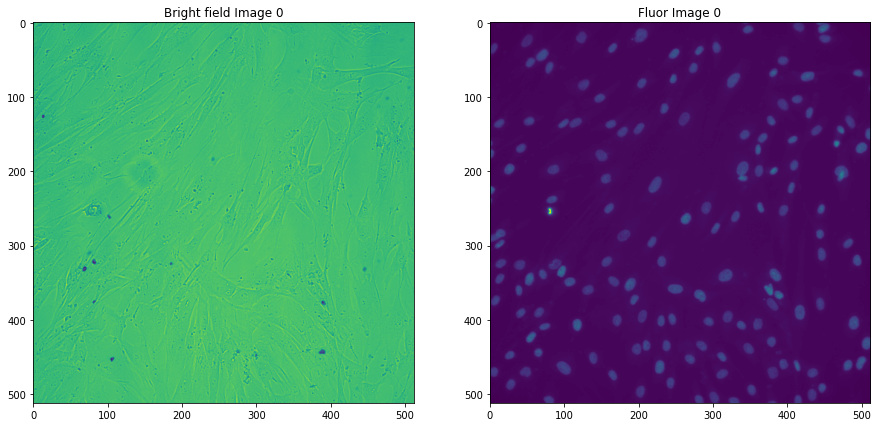

In [12]:
# View an example of image and corresponding mask 
show_images = 1
print(bright[100])
print(fluor[100])
for i in range(show_images):
    img_view  = imread(bright[100])
    mask_view = imread(fluor[100])
    image_resized = resize(img_view, (512, 512),
                       anti_aliasing=True)
    mask_resized = resize(mask_view, (512, 512),
                       anti_aliasing=True)
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(image_resized)
    arr[0].set_title('Bright field Image '+ str(i))
    arr[1].imshow(mask_resized)
    arr[1].set_title('Fluor Image '+ str(i))

512 512 1
512 512 1
Found model '2D_versatile_fluo' for 'StarDist2D'.


2022-04-15 10:23:43.014745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-15 10:23:43.015387: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
X Shape: (350, 512, 512, 1)
Y shape: (350, 512, 512, 1)


Text(0.5, 1.0, 'Processed Masked Image ')

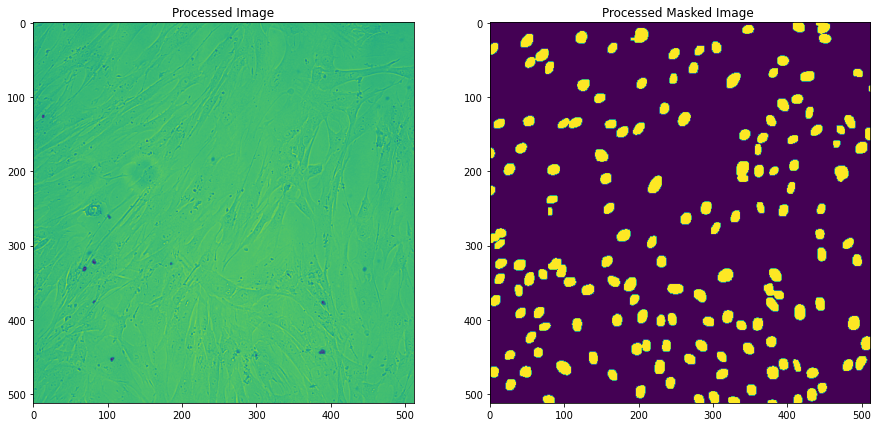

In [13]:
# Define the desired shape
target_shape_img = [512,512, 1]
target_shape_mask = [512, 512, 1]

# Process data using apt helper function
X, y = PreprocessData(bright, fluor, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
#print(np.unique(y))


# Visualize the output
image_index = 100
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

1


Text(0.5, 1.0, 'Processed Masked Image ')

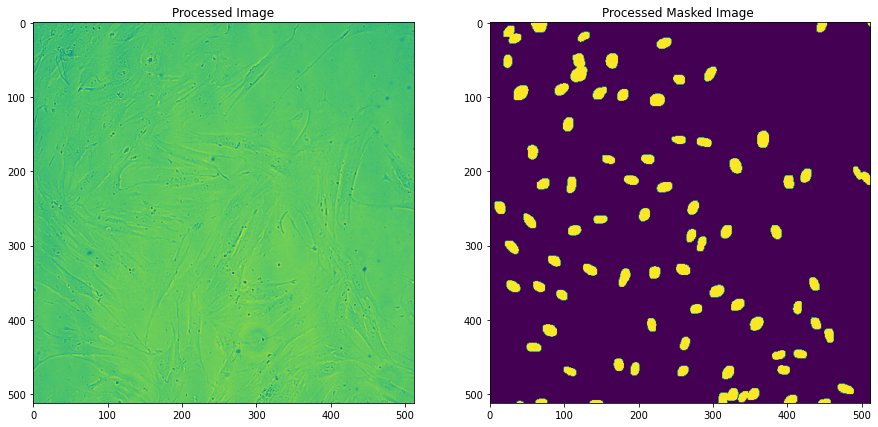

In [14]:
image_index = 200
print (np.max(y[image_index]))
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index])
arr[1].set_title('Processed Masked Image ')

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state = 123)

In [16]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(512,512,1), n_filters=128, n_classes=2)

In [17]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 512, 512, 12  1280        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 512, 512, 12  147584      ['conv2d_2[0][0]']               
                                8)                                                          

 concatenate_4 (Concatenate)    (None, 128, 128, 10  0           ['conv2d_transpose_1[0][0]',     
                                24)                               'batch_normalization_2[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 51  4719104     ['concatenate_4[0][0]']          
                                2)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 51  2359808     ['conv2d_14[0][0]']              
                                2)                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 25  1179904    ['conv2d_15[0][0]']              
 spose)   

In [18]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

batch_size = 16

In [ ]:
results = unet.fit(X_train, y_train, batch_size=batch_size, epochs = 30, validation_data=(X_valid, y_valid))

Epoch 1/30
16/16 [==============================] - 2556s 160s/step - loss: 3111.2947 - accuracy: 0.5693 - val_loss: 0.3394 - val_accuracy: 0.9314
Epoch 2/30
16/16 [==============================] - 2532s 159s/step - loss: 0.7961 - accuracy: 0.8929 - val_loss: 0.4382 - val_accuracy: 0.9197
Epoch 3/30
16/16 [==============================] - 2569s 161s/step - loss: 1.1737 - accuracy: 0.8619 - val_loss: 0.3174 - val_accuracy: 0.9300
Epoch 4/30
16/16 [==============================] - 2571s 161s/step - loss: 0.3249 - accuracy: 0.9258 - val_loss: 0.3086 - val_accuracy: 0.9307
Epoch 5/30
16/16 [==============================] - 2572s 161s/step - loss: 0.3160 - accuracy: 0.9261 - val_loss: 0.2991 - val_accuracy: 0.9314
Epoch 6/30
16/16 [==============================] - 2549s 160s/step - loss: 0.3106 - accuracy: 0.9262 - val_loss: 0.2922 - val_accuracy: 0.9314
Epoch 7/30
16/16 [==============================] - 2524s 158s/step - loss: 0.2993 - accuracy: 0.9262 - val_loss: 0.2814 - val_accura

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

In [ ]:
unet.evaluate(X_valid, y_valid)

In [ ]:
unet.save('my_model_BJ.h5')

In [ ]:
# Results of Validation Dataset
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis = -1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(35, 35))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')
    plt.savefig('plot{}.png'.format(index))



In [ ]:
# Add any index to contrast the predicted mask with actual mask
for i in range (len(X_valid)):
    if i >2:
        break
    VisualizeResults(i) 